# IndicWav2Vec Workshop-2022

## Table of Contents:
1. 🔥 Demo of IndicWav2Vec-Hindi ASR Model using HuggingFace
2. 🕒 Fine-Tuning ASR Model from Checkpoint
3. 🤖 Improving Performance of ASR System using Language Model
4. 🚀 Deploying Models using Gradio


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI4Bharat/IndicWav2Vec/blob/main/workshop-2022/notebooks/IndicWav2Vec_Workshop_2022.ipynb)

## 1. Quick Demo (using HuggingFace)

### i. Installation and Setup

Install Ubuntu/Debian Packages - 

In [ ]:
! apt-get install build-essential libboost-all-dev cmake zlib1g-dev libbz2-dev liblzma-dev
! add-apt-repository ppa:savoury1/ffmpeg4 -y && apt-get update && apt-get install ffmpeg # Upgrade ffmpeg version only if unable to load mp3 file

Install Python Packages - 
1. [PyTorch](https://pytorch.org/get-started/locally/)
2. [torchaudio](https://pytorch.org/get-started/locally/)
3. HuggingFace's [Transformers](https://huggingface.co/docs/transformers/installation)
4. HuggingFace's [Datasets](https://huggingface.co/docs/datasets/installation)
5. Kensho's [pyctcdecode](https://github.com/kensho-technologies/pyctcdecode)
6. [Kenlm's](https://github.com/kpu/kenlm) Python Bindings 
7. [Gradio](https://gradio.app/getting_started/)

For detailed instruction, please follow the above links to their respective documentation pages.

In [ ]:
! pip install transformers datasets pyctcdecode soundfile gradio;
! pip install https://github.com/kpu/kenlm/archive/master.zip;

  Using cached https://github.com/kpu/kenlm/archive/master.zip


Import Packages - 

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2Processor, Wav2Vec2ProcessorWithLM, pipeline
import torchaudio
import torch
from datasets import load_dataset

from IPython.display import Audio, display
import sys
import gradio as gr

### ii. [Appendix] Helper Functions

Load Audio from File

In [13]:
def load_audio_from_file(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    num_channels, _ = waveform.shape
    if num_channels == 1:
        return waveform[0], sample_rate
    else:
        raise ValueError("Waveform with more than 1 channels are not supported.")

#### Insight: Why HuggingFace?

### iii. Data Preparation: Load Samples

Define Audio Sample

In [ ]:
%cd /content/IndicWav2Vec

TARGET_SAMPLE_RATE = 16000
SAMPLE_AUDIO_PATH = "workshop-2022/samples/blindtest_300139.wav"

# Optionally 
cv_dataset_iter = iter(load_dataset("common_voice", "hi", split="test")) # add streaming=True for slow network

/content/IndicWav2Vec


Reusing dataset common_voice (/root/.cache/huggingface/datasets/common_voice/hi/6.1.0/a1dc74461f6c839bfe1e8cf1262fd4cf24297e3fbd4087a711bd090779023a5e)


Load Sample and Resample audio to 16Khz

In [ ]:
#Load from file
# waveform, sample_rate = load_audio_from_file(SAMPLE_AUDIO_PATH)

#Optionally, Load from common-voice iterator
sample = next(cv_dataset_iter)
waveform, sample_rate = torch.tensor(sample["audio"]["array"]), sample["audio"]["sampling_rate"]

#Resample
resampled_audio = torchaudio.functional.resample(waveform, sample_rate, TARGET_SAMPLE_RATE)

#### Visualize Sample

In [ ]:
display(Audio(resampled_audio.numpy(), rate=TARGET_SAMPLE_RATE))

### iv. Run Inference

Define Global Variables

In [ ]:
# Specify the Hugging Face Model Id 
MODEL_ID = "ai4bharat/indicwav2vec-hindi"

# Specify the Device Id on where to put the model
DEVICE_ID = "cuda" if torch.cuda.is_available() else "cpu"

# Specify Decoder Type:
DECODER_TYPE = "greedy" # Choose "LM" decoding or "greedy" decoding

Load Model and Processor from Huggingface Hub

In [ ]:
# Load Model
model_instance = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE_ID)

if DECODER_TYPE == "greedy":
    # Load Processor without language model
    processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
else:
    # Load Processor with language model
    processor = Wav2Vec2ProcessorWithLM.from_pretrained(MODEL_ID)

Process Audio Data and Run Forward Pass to obtain Logits

In [ ]:
# Process audio data
input_tensor = processor(resampled_audio, return_tensors="pt", sampling_rate=TARGET_SAMPLE_RATE).input_values

# Run forward pass
with torch.no_grad():
    logits = model_instance(input_tensor.to(DEVICE_ID)).logits.cpu()

Decode Logits

In [ ]:
if DECODER_TYPE == "greedy":
    prediction_ids = torch.argmax(logits, dim=-1)
    output_str = processor.batch_decode(prediction_ids)[0]
    print(f"Greedy Decoding: {output_str}")
else:
    output_str = processor.batch_decode(logits.numpy()).text[0]
    print(f"LM Decoding: {output_str}")

Greedy Decoding: कांस्टेबल बन मनोज बाजपेयी दिखा रहे हैं तांडव


### v. Demo App

Create  HuggingFace's pipeline for automatic speech recognition

In [ ]:
device_no = 0 if DEVICE_ID == "cuda" else -1
if DECODER_TYPE == "greedy":
    asr = pipeline("automatic-speech-recognition", model=model_instance, tokenizer=processor.tokenizer, 
                    feature_extractor=processor.feature_extractor, decoder=None, device=device_no)
else:
    asr = pipeline("automatic-speech-recognition", model=model_instance, tokenizer=processor.tokenizer, 
                    feature_extractor=processor.feature_extractor, decoder=processor.decoder, device=device_no)

Create Gradio App

In [ ]:
def transcribe(input_file, language="Hindi", decoding_type="greedy", history=[]):
    history = history or []
    transcription = asr(input_file.name, chunk_length_s=5, stride_length_s=1)["text"]

    history.append({
        "model_id": MODEL_ID,
        "language": language,
        "decoding_type": decoding_type,
        "transcription": transcription,
        "error_message": None
    })

    html_output = "<div class='result'>"
    for item in history:
        if item["error_message"] is not None:
            html_output += f"<div class='result_item result_item_error'>{item['error_message']}</div>"
        else:
            url_suffix = " + LM" if decoding_type == "lm" else ""
            html_output += "<div class='result_item result_item_success'>"
            html_output += f'<strong><a target="_blank" href="https://huggingface.co/{MODEL_ID}">{MODEL_ID}{url_suffix}</a></strong><br/><br/>'
            html_output += f'{item["transcription"]}<br/>'
            html_output += "</div>"
    html_output += "</div>"

    return html_output, history

gr.Interface(
    transcribe,
    inputs=[
        gr.inputs.Audio(source="microphone", type="file", label="Record here..."),
        gr.inputs.Radio(label="Language", choices=["Hindi"]),
        gr.inputs.Radio(label="Decoding type", choices=["greedy", "lm"]),
        "state"
    ],
    outputs=[
        gr.outputs.HTML(label="Outputs"),
        "state"
    ],
    title="Speech to Text  <=>  IndicWav2Vec",
    description="",
    css="""
    .result {display:flex;flex-direction:column}
    .result_item {padding:15px;margin-bottom:8px;border-radius:15px;width:100%}
    .result_item_success {background-color:mediumaquamarine;color:white;align-self:start}
    .result_item_error {background-color:#ff7070;color:white;align-self:start}
    """,
    allow_flagging="never"
).launch(enable_queue=True)


/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:319: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:183: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
Running on public URL: https://42595.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7fb7045e9e90>,
 'http://127.0.0.1:7873/',
 'https://42595.gradio.app')

## 2. Fine-Tuning ASR Model

### i. Installation and Setup

Prerequisite
- Torch already installed

Install Required System Packages

In [ ]:
!apt install -y liblzma-dev libbz2-dev libzstd-dev libsndfile1-dev libopenblas-dev libfftw3-dev libgflags-dev libgoogle-glog-dev build-essential cmake libboost-system-dev libboost-thread-dev libboost-program-options-dev libboost-test-dev libeigen3-dev zlib1g-dev libbz2-dev liblzma-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
libboost-program-options-dev is already the newest version (1.65.1.0ubuntu1).
libboost-program-options-dev set to manually installed.
libboost-system-dev is already the newest version (1.65.1.0ubuntu1).
libboost-system-dev set to manually installed.
libboost-thread-dev is already the newest version (1.65.1.0ubuntu1).
libboost-thread-dev set to manually installed.
libboost-test-dev is already the newest version (1.65.1.0ubuntu1).
libboost-test-dev set to manually installed.
libopenblas-dev is already the newest version (0.2.20+ds-4).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
libbz2-dev is already the newest version (1.0.6-8.1ubuntu0.2).
liblzma-dev is already the newest version (5.2.2-1.3ubuntu0.1).
libsndfile1-dev is already the newest version (1.0.28-4ubuntu0.18.04.2).
The following package was automatically i

Clone IndicWav2Vec, Fairseq, KenLM and Flashlight repo from Github

In [ ]:
!rm -rf IndicWav2Vec fairseq kenlm flashlight
!git clone https://github.com/AI4Bharat/IndicWav2Vec.git
!git clone https://github.com/pytorch/fairseq.git
!git clone https://github.com/kpu/kenlm.git
!git clone https://github.com/flashlight/flashlight.git

Cloning into 'IndicWav2Vec'...
remote: Enumerating objects: 1847, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1847 (delta 108), reused 106 (delta 92), pack-reused 1715
Receiving objects: 100% (1847/1847), 127.75 MiB | 24.87 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Cloning into 'fairseq'...
remote: Enumerating objects: 32100, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 32100 (delta 116), reused 147 (delta 77), pack-reused 31889
Receiving objects: 100% (32100/32100), 22.35 MiB | 19.52 MiB/s, done.
Resolving deltas: 100% (23499/23499), done.
Cloning into 'kenlm'...
remote: Enumerating objects: 14102, done.
remote: Counting objects: 100% (415/415), done.
remote: Compressing objects: 100% (290/290), done.
remote: Total 14102 (delta 126), reused 371 (delta 111), pack-reused 13687
Receiving objects: 100% (14102/14102), 5.89 MiB | 20.32

Install Python Packages

In [ ]:
%cd /content/IndicWav2Vec
!pip install packaging soundfile swifter -r w2v_inference/requirements.txt
%cd ..

/content/IndicWav2Vec
Checking out files: 100% (662/662), done.
Branch 'new-lm' set up to track remote branch 'new-lm' from 'origin'.
Switched to a new branch 'new-lm'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 825 kB 14.5 MB/s 
     |████████████████████████████████| 302 kB 66.0 MB/s 
     |████████████████████████████████| 40 kB 5.8 MB/s 
     |████████████████████████████████| 72 kB 1.1 MB/s 
     |████████████████████████████████| 15.3 MB 20 kB/s 
     |████████████████████████████████| 9.9 MB 20.1 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 10.6 MB 43.9 MB/s 
     |████████████████████████████████| 308 kB 49.4 MB/s 
     |████████████████████████████████| 1.8 MB 53.8 MB/s 
     |████████████████████████████████| 8.8 MB 46.3 MB/s 
     |████████████████████████████████| 281 kB 75.5 MB/s 
     |████████████████████████████████| 2.8

/content


Build Fairseq

In [ ]:
%cd /content/fairseq
!git checkout cf8ff8c3c5242e6e71e8feb40de45dd699f3cc08
!pip install ./
%cd /content

/content/fairseq
Note: checking out 'cf8ff8c3c5242e6e71e8feb40de45dd699f3cc08'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at cf8ff8c3 Add unittests for jitting EMA model
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fairseq
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find dis

Build KenLM

In [ ]:
%cd /content/kenlm
!mkdir -p build
%cd build
!cmake .. 
!make -j 16
%cd /content

/content/kenlm
/content/kenlm/build
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Failed
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Found Boost: /usr/include (found suitable version "1.65.1", minimum required is "1.41.0") foun

Build Flashlight

In [ ]:
%cd /content/flashlight/bindings/python
!git checkout 06ddb51857ab1780d793c52948a0759f0ccc6ddb
!export USE_MKL=0 && export KENLM_ROOT="/content/kenlm/" && python setup.py install
%cd /content

/content/flashlight/bindings/python
Note: checking out '06ddb51857ab1780d793c52948a0759f0ccc6ddb'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 06ddb518 improve python binding/ready for pypi (#404)
running install
running bdist_egg
running egg_info
creating flashlight.egg-info
writing flashlight.egg-info/PKG-INFO
writing dependency_links to flashlight.egg-info/dependency_links.txt
writing top-level names to flashlight.egg-info/top_level.txt
writing manifest file 'flashlight.egg-info/SOURCES.txt'
package init file 'flashlight/__init__.py' not found (or not a regular file)
package init file 'flashlight/lib/audio/__init__

#### Insight: End to End ASR Training/Inference Pipeline.

Change directory to IndicWav2Vec

In [ ]:
%cd /content/IndicWav2Vec

/content/IndicWav2Vec


### ii. Data Preparation: Manifest Creation

Visualize Manifest Directory Structure

In [ ]:
!apt-get -y install tree && tree -dC workshop-2022/asr_data/noa_training_1hr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 281 not upgraded.
workshop-2022/asr_data/noa_training_1hr
├── audio
│   ├── train
│   │   └── hindi
│   │       ├── Regional-Bhopal-Hindi-0705-201810168277
│   │       ├── Regional-Bhopal-Hindi-0705-2018102573612
│   │       ├── Regional-Bhopal-Hindi-0705-201891612819
│   │       ├── Regional-Bhopal-Hindi-0705-2019102810393
│   │       ├── Regional-Bhopal-Hindi-0705-2019121310437
│   │       ├── Regional-Bhopal-Hindi-0705-20191473718
│   │       ├── Regional-Bhopal-Hindi-0705-20193593412
│   │       ├── Regional-Bhopal-Hindi-0705-2019418451
│   │       ├── Regional-Bhopal-Hindi-0705-201942481511
│   │       ├── Regional-Bhopal-Hindi-0705-201953174154
│   │       ├── R

### iii. Start Finetuning

Download Model Checkpoint

In [ ]:
%cd /content/IndicWav2Vec/workshop-2022
!mkdir models
# !mkdir checkpoints
!cd models && rm -rf hi_mucs_dc.pt* && wget https://storage.googleapis.com/ai4b-speech/TTS/KENLM/hi_mucs_dc.pt
!cd models && rm -rf checkpoint_ft.pt* && wget https://storage.googleapis.com/ai4b-speech/TTS/KENLM/checkpoint_ft.pt
%cd ..

/content/IndicWav2Vec/workshop-2022
mkdir: cannot create directory ‘models’: File exists
--2022-07-28 08:44:56--  https://storage.googleapis.com/ai4b-speech/TTS/KENLM/checkpoint_ft.pt
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 142.250.148.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3808863698 (3.5G) [application/octet-stream]
Saving to: ‘checkpoint_ft.pt’

checkpoint_ft.pt    100%[===================>]   3.55G   285MB/s    in 15s     

2022-07-28 08:45:10 (250 MB/s) - ‘checkpoint_ft.pt’ saved [3808863698/3808863698]

/content/IndicWav2Vec


Insight: Conifg Setup: What to change and what to not?

Setup Wandb

In [ ]:
!wandb login 

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


Run Finetuning

In [9]:
!fairseq-hydra-train task.data=${PWD}"/workshop-2022/asr_data/noa_training_1hr/manifest/hindi" \
    dataset.max_tokens=200000 \
    common.log_interval=20 \
    common.wandb_project=tutorial-training \
    model.freeze_finetune_updates=1000 \
    model.w2v_path=${PWD}"/workshop-2022/models/checkpoint_ft.pt" \
    checkpoint.save_dir=${PWD}"/workshop-2022/models/indicwav2vec_noa" \
    checkpoint.restore_file=${PWD}"/workshop-2022/models/hi_mucs_dc.pt" \
    distributed_training.distributed_world_size=1 \
    +optimization.update_freq='[1]' \
    +optimization.lr=[0.0001] \
    optimization.max_update=100000 \
    checkpoint.save_interval_updates=10000 \
    --config-dir ${PWD}"/finetune_configs" \
    --config-name ai4b_xlsr 


[2022-07-28 09:07:42,175][fairseq_cli.train][INFO] - {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 20, 'log_format': 'tqdm', 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': 'tutorial-training', 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': None, 'path': None, 'p

### iv. Inference

Import Statements

In [21]:
import math
import torch
import pydub
from omegaconf import OmegaConf
import torchaudio
from IPython.display import Audio, display

Load Packages from IndicWav2Vec Reop

In [4]:
%cd /content/IndicWav2Vec

from inference.support import load_model, load_data
from inference.support import W2lKenLMDecoder,W2lViterbiDecoder

/content/IndicWav2Vec


In [33]:
SAMPLE_AUDIO_PATH = "workshop-2022/samples/blindtest_300139.wav"
TARGET_SAMPLE_RATE = 16000

DEVICE_ID = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = 'workshop-2022/models/indicwav2vec_noa/checkpoint_last.pt'
# MODEL_PATH = 'workshop-2022/models/hi_mucs_dc.pt'

Load Model

In [ ]:
%cd /content/IndicWav2Vec
# load model
model,char_dict = load_model(MODEL_PATH)
model.to(DEVICE_ID)
%cd /content

/content/IndicWav2Vec
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed for path: workshop-2022/models/hi_mucs_dc.pt. Retrying..
Loading model..
Model loading failed f

Load Sample

Helper Function

In [16]:
def load_audio_from_file(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    num_channels, _ = waveform.shape
    if num_channels == 1:
        return waveform[0], sample_rate
    else:
        raise ValueError("Waveform with more than 1 channels are not supported.")

In [23]:
# load sample
waveform, sample_rate = load_audio_from_file(SAMPLE_AUDIO_PATH)
# resample
resampled_audio = torchaudio.functional.resample(waveform, sample_rate, TARGET_SAMPLE_RATE)
# display audio sample
display(Audio(resampled_audio.numpy(), rate=TARGET_SAMPLE_RATE))

Load Viterbi Decoder

In [24]:
viterbi_arg = OmegaConf.create({'nbest':1})
viterbi_generator = W2lViterbiDecoder(viterbi_arg, char_dict)

Helper Function: To Run Inference

In [27]:
def infer(feature, generator, DEVICE):
    if DEVICE != 'cpu' and torch.cuda.is_available():
        feature = feature.to(DEVICE)
    sample = {"net_input":{"source":None,"padding_mask":None}}
    sample["net_input"]["source"] = feature.unsqueeze(0)
    if DEVICE != 'cpu' and torch.cuda.is_available():
        sample["net_input"]["padding_mask"] = torch.BoolTensor(sample["net_input"]["source"].size(1)).fill_(False).unsqueeze(0).to(DEVICE)
    else:
        sample["net_input"]["padding_mask"] = torch.BoolTensor(sample["net_input"]["source"].size(1)).fill_(False).unsqueeze(0)

    with torch.no_grad():
        hypo = generator.generate([model], sample, prefix_tokens=None)
    hyp_pieces = char_dict.string(hypo[0][0]["tokens"].int().cpu())
    tr = hyp_pieces.replace(' ','').replace('|',' ').strip()
    return tr

Run Greedy Inference

In [28]:
output_str = infer(waveform, viterbi_generator, DEVICE_ID)
print(f"Greedy Output: {output_str}")

Greedy Output: सरननननानननननानाननानननननाग


## 3. Improving Performance using Language Model

### i. Installation and Setup

Prerequisite
- Fairseq
- `IndicWav2Vec` cloned from github  
- KenLM 
- Flashlight
- Other Linux Dependencies

Install Python Packages

In [ ]:
#! pip install pyctcdecode pandas matplotlib indic-nlp-library tqdm regex
#! pip install https://github.com/kpu/kenlm/archive/master.zip
!pip install git+https://github.com/sutariyaraj/indic-num2words

  Cloning https://github.com/sutariyaraj/indic-num2words to /tmp/pip-req-build-ll4_t5gm
  Running command git clone -q https://github.com/sutariyaraj/indic-num2words /tmp/pip-req-build-ll4_t5gm


#### Insight: Greedy vs Beam Search Decoding

### ii. Dataset Preparation: Clean Text Corpus and Create Lexicon

Visualize LM Data File Structure

In [ ]:
!tree workshop-2022/lm_data/indic_corp_100k

workshop-2022/lm_data/indic_corp_100k
├── hindi_dict.txt
└── hi_sents.txt

0 directories, 2 files


Visualize Content of the Folder

In [ ]:
%cd /content/IndicWav2Vec/workshop-2022/lm_data
!var="$(cat indic_corp_100k/hindi_dict.txt | wc -l)" && echo "Total Items in hindi_dict.txt = $var"$'\n'
!echo "Displaying first 10 items below..."$'\n' && head indic_corp_100k/hindi_dict.txt
%cd /content

/content/IndicWav2Vec/workshop-2022/lm_data
Total Items in hindi_dict.txt = 64

Displaying first 10 items below...

|
ँ
ं
ः
अ
आ
इ
ई
उ
ऊ
/content


In [ ]:
%cd /content/IndicWav2Vec/workshop-2022/lm_data
!var="$(cat indic_corp_100k/hi_sents.txt | wc -l)" && echo "Total Items in hi_sents.txt = $var"$'\n'
!echo "Displaying first 10 sentences below ..."$'\n' && head indic_corp_100k/hi_sents.txt
%cd /content

/content/IndicWav2Vec/workshop-2022/lm_data
Total Items in hi_sents.txt = 100000

Displaying first 10 sentences below ...

आवेदन करने की आखिरी तारीख 31 जनवरी, 2020 है।
इतनी दुआ कर दो हमारे लिए कि जितना प्यार दुनिया ने आपको दिया है, बस उतना ही हमें भी मिल जाए|”
मोदी सरकार के पहले कार्यकाल में भी तीन तलाक को लेकर बिल लाया गया था, हालांकि तब यह राज्यसभा में पास नहीं हो पाया था.
भाजपा के दिवंगत नेता प्रमोद महाजन की बेटी पूनम महाजन को सचिव बनाया गया है.
ऐसी स्थिति में एक न्यायपूर्ण सरकार सार्वजनिक वित्त का इस तरह इस्तेमाल करती है कि संसाधनों का आवंटन, सभी के उपभोग वाले उत्पादों की व्यवहार्यता और समग्र वृहद-आर्थिक प्रबंधन 'निष्पक्षता के रूप में न्याय' को बढ़ाए।
दिलचस्प है कि डीसीएचएल के चेयरमैन टी वेंकटरमन रेड्डी और वाइस चेयरमैन टी विनायक रवि रेड्डी इस बैठक में मौजूद नहीं थे।
इस आम चुनाव में भाजपा नेता सतीश कुमार गौतम को सबसे अधिक 6 लाख 56 हजार 215 वोट प्राप्त हुए.
आयरलैंड टीम के विकेटकीपर बल्लेबाज नियाल ओ'ब्रायन ने अंतर्राष्ट्रीय क्रिकेट से संन्यास का ऐलान कर दिया है। साल 2002 में डेनमार्क 

In [ ]:
%cd /content/IndicWav2Vec/
!python lm_training/utils/prepare_data.py hi -d ${PWD}"/workshop-2022/lm_data/indic_corp_100k" \
    --data_type "C" --drop_rows strict --dict_dir ${PWD}"/workshop-2022/lm_data/indic_corp_100k" \
    --out_dir ${PWD}"/workshop-2022/models/indic_corp_lm"
%cd /content

/content/IndicWav2Vec
----------------------------------------------------------------------------
-------------------Cleaning and Stats Calculation #1 ...-------------------
	Loading Data...
	Done Loading Data!
	Starting Processing...
100% 100000/100000 [00:03<00:00, 26698.16it/s]
	Done Processing!

-------------------Cleaning, Filtering and Stats Calculation #2 ...-------------------
	Saving Final Sentences in txt format...
	Saving Unique Words and their frequencies...
	Saving Stats and Stats Plots
----------------------------------------------------------------------------
/content


### iii. Start Training

In [ ]:
%cd /content/IndicWav2Vec/
!python lm_training/utils/train_kenlm.py hi --lm_base_dirpath ${PWD}"/workshop-2022/models/indic_corp_lm" \
    --lm_dirname "lm" --topk 10000 --kenlm_bins "../kenlm/build/bin" \
    --arpa_order 6 --max_arpa_memory "90%" --arpa_prune "0|0|0|0|1|2" \
    --binary_a_bits 255 --binary_q_bits 8 --binary_type trie
%cd /content

/content/IndicWav2Vec

Step 1:	Preparing Data for LM-------------------------------------------
Creating a temporary copy of ALL_SENTS!...
Merging all "M_*words_counters.tsv" files!...
Corpus Stats: Total Words: 1874607	 Total Unique Words: 81713	 Top-k:10000	 %age top-k: 12.24%
Combined Unique Words in the Lexicon, #10000

Step 2:	Building LM-------------------------------------------
Creating ARPA file ...

=== 1/5 Counting and sorting n-grams ===
Reading /content/IndicWav2Vec/workshop-2022/models/indic_corp_lm/hindi/itms/temp_sents.txt.gz
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
tcmalloc: large alloc 12735193088 bytes == 0x56296d020000 @  0x7f557e2b31e7 0x56296ac72912 0x56296ac0d62e 0x56296abec41b 0x56296abd8176 0x7f557c44cbf7 0x56296abd9cda
tcmalloc: large alloc 67921018880 bytes == 0x562c649ee000 @  0x7f557e2b31e7 0x56296ac72912 0x56296ac6193a 0x56296ac62378 0x56296abec438 0x56296abd8176 0x7f557c44cbf7 0x56296abd9cda
****

### iv. Inference

Load LM Decoder

In [ ]:
%cd /content/IndicWav2Vec
lm_details = {
    "lexicon":"/content/IndicWav2Vec/workshop-2022/models/indic_corp_lm/hindi/lm/topk-10000_lexicon.lst", 
    "kenlm_model":"/content/IndicWav2Vec/workshop-2022/models/indic_corp_lm/hindi/lm/topk-10000_lm.binary", 
    "beam":64,
    "beam_size_token": 1000, 
    "beam_threshold":250,
    "lm_weight":0.5, 
    "word_score":2.0, 
    "sil_weight":0.0,
    "unk_weight": -math.inf
}
lmarg = OmegaConf.create(lm_details)
kenlm_generator = W2lKenLMDecoder(lmarg, char_dict)

Run Beam Search Decoding with LM

In [ ]:
output_str = infer(waveform, kenlm_generator, DEVICE_ID)
print(f"LM Output: {output_str}")

## 4. Deploying Models

### i. Installation and Setup

Install git-lfs

In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
!apt-get install git-lfs
!git lfs install
# !git config --global user.email "ramanabhigyan@gmail.com"
# !git config --global user.name "Abhigyan Raman"

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (3.2.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 281 not upgraded.
Updated Git hooks.
Git LFS initialized.


Install Gradio

In [ ]:
!pip install gradio

Login to huggingface-hub

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

Import Statements

In [ ]:
from transformers import Wav2Vec2Config
from huggingface_hub import create_repo, Repository

import logging
import sys
import gradio as gr
from transformers import pipeline, AutoModelForCTC, Wav2Vec2Processor, Wav2Vec2ProcessorWithLM

### ii. Export models to HuggingFace

Create and Initialize Repo

In [ ]:
repo_url = create_repo("indicwav2vec-hindi", organization="ai4bharat")
repo = Repository(local_dir="workshop-2022/models/indicwav2vec_noa_hf", clone_from=repo_url)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:94: FutureWarning: `name` and `organization` input arguments are deprecated and will be removed in v0.10. Pass `repo_id` instead.
  FutureWarning,
Cloning https://huggingface.co/ai4bharat/indicwav2vec-hindi into local empty directory.


Save config.json from a "similar" architecture in huggingface

In [ ]:
config = Wav2Vec2Config.from_pretrained('facebook/wav2vec2-large-960h-lv60-self')
config.save_pretrained('workshop-2022/models/indicwav2vec_noa_hf');

Convert ASR model to Huggingface's format

In [ ]:
%cd "/content/IndicWav2Vec"
!python workshop-2022/utils/convert_wav2vec2_original_pytorch_checkpoint_to_pytorch.py \
    --pytorch_dump_folder ${PWD}"/workshop-2022/models/indicwav2vec_noa_hf" \
    --checkpoint_path ${PWD}"/workshop-2022/models/indicwav2vec_noa/checkpoint_best.pt" \
    --config_path ${PWD}"/workshop-2022/models/indicwav2vec_noa_hf/config.json" \
    --dict_path ${PWD}"/workshop-2022/asr_data/noa_training_1hr/manifest/hindi/dict.ltr.txt"
%cd /content

Convert both ASR and LM model to Huggingface's format

In [ ]:
%cd "/content/IndicWav2Vec"
!python workshop-2022/utils/convert_wav2vec2_original_pytorch_checkpoint_to_pytorch.py \
    --pytorch_dump_folder ${PWD}"/workshop-2022/models/indicwav2vec_noa_hf" \
    --checkpoint_path ${PWD}"/workshop-2022/models/indicwav2vec_noa/checkpoint_best.pt" \
    --config_path ${PWD}"/workshop-2022/models/indicwav2vec_noa_hf/config.json" \
    --dict_path ${PWD}"/workshop-2022/asr_data/noa_training_1hr/manifest/hindi/dict.ltr.txt" \
    --lm_path ${PWD}"/workshop-2022/models/indic_corp_lm/hindi/lm/lm.binary" \
    --lexicon_path ${PWD}"/workshop-2022/models/indic_corp_lm/hindi/lm/lexicon.lst" \
    --alpha 0.5 \
    --beta 1.5 \
    --with_LM
%cd /content

Push to Huggingface Model Hub

In [ ]:
%cd "/content/IndicWav2Vec/workshop-2022/models/indicwav2vec_noa_hf"
!huggingface-cli lfs-enable-largefiles .
!git lfs track "*.binary"
!git add .
!git commit -m "added language model"
!git push origin main
%cd /content

/content/indicwav2vec-hindi
Local repo set up for largefiles
Tracking "*.binary"
[main e746fa3] added language model
 3 files changed, 1 insertion(+)
 create mode 100644 gradio_queue.db
 create mode 100644 gradio_queue.db-journal
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 389 bytes | 389.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
To https://huggingface.co/ai4bharat/indicwav2vec-hindi
   1d357da..e746fa3  main -> main
/content


### iii. Deploying as Gradio app

Setup logging and Global Variables

In [ ]:
# Basic Logger
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Variables
LARGE_MODEL_BY_LANGUAGE = {
    "Hindi": {"model_id": "ai4bharat/indicwav2vec-hindi", "has_lm": True},
}
LANGUAGES = sorted(LARGE_MODEL_BY_LANGUAGE.keys())
CACHED_MODELS_BY_ID = {}
DEVICE_ID = 0 if torch.cuda.is_available() else -1

Defin run function

In [ ]:
def run(input_file, language, decoding_type, history):
    logger.info(f"Running ASR {language}-{decoding_type} for {input_file}")
    history = history or []
    model = LARGE_MODEL_BY_LANGUAGE.get(language, None)

    if decoding_type == "lm" and not model["has_lm"]:
        history.append({
            "error_message": f"lm not available for {language} language :("
        })
    else:
        model_instance = CACHED_MODELS_BY_ID.get(model["model_id"], None)
        if model_instance is None:
            model_instance = AutoModelForCTC.from_pretrained(model["model_id"])
            CACHED_MODELS_BY_ID[model["model_id"]] = model_instance

        if decoding_type == "lm":
            processor = Wav2Vec2ProcessorWithLM.from_pretrained(model["model_id"])
            asr = pipeline("automatic-speech-recognition", model=model_instance, tokenizer=processor.tokenizer, 
                           feature_extractor=processor.feature_extractor, decoder=processor.decoder, device=device_no)
        else:
            processor = Wav2Vec2Processor.from_pretrained(model["model_id"])
            asr = pipeline("automatic-speech-recognition", model=model_instance, tokenizer=processor.tokenizer, 
                           feature_extractor=processor.feature_extractor, decoder=None, device=device_no)

        transcription = asr(input_file.name, chunk_length_s=5, stride_length_s=1)["text"]
        logger.info(f"Transcription for {input_file}: {transcription}")
        history.append({
            "model_id": model["model_id"],
            "language": language,
            "decoding_type": decoding_type,
            "transcription": transcription,
            "error_message": None
        })

    html_output = "<div class='result'>"
    for item in history:
        if item["error_message"] is not None:
            html_output += f"<div class='result_item result_item_error'>{item['error_message']}</div>"
        else:
            url_suffix = " + LM" if item["decoding_type"] == "LM" else ""
            html_output += "<div class='result_item result_item_success'>"
            html_output += f'<strong><a target="_blank" href="https://huggingface.co/{item["model_id"]}">{item["model_id"]}{url_suffix}</a></strong><br/><br/>'
            html_output += f'{item["transcription"]}<br/>'
            html_output += "</div>"
    html_output += "</div>"

    return html_output, history


Define Gradio Interface

In [ ]:
gr.Interface(
    run,
    inputs=[
        gr.inputs.Audio(source="microphone", type="file", label="Record here..."),
        gr.inputs.Radio(label="Language", choices=LANGUAGES),
        gr.inputs.Radio(label="Decoding type", choices=["greedy", "lm"]),
        "state"
    ],
    outputs=[
        gr.outputs.HTML(label="Outputs"),
        "state"
    ],
    title="Speech to Text <=> IndicWav2Vec",
    description="",
    css="""
    .result {display:flex;flex-direction:column}
    .result_item {padding:15px;margin-bottom:8px;border-radius:15px;width:100%}
    .result_item_success {background-color:mediumaquamarine;color:white;align-self:start}
    .result_item_error {background-color:#ff7070;color:white;align-self:start}
    """,
    allow_flagging="never"
).launch(enable_queue=True)

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:319: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:183: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
Running on public URL: https://32910.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f1a2228d6d0>,
 'http://127.0.0.1:7862/',
 'https://32910.gradio.app')

# Pretraining your own models
For pretraining you own models, you need unlabelled data. The data can be processed through our already. uilt pipeline which includes Voiced Activity Detection, SNR Filtering and finally chunking it into small pieces to allow the model to train.
The pretraining and data processing scripts can be found [here](https://github.com/AI4Bharat/IndicWav2Vec)
The entire pipeline is as follows:

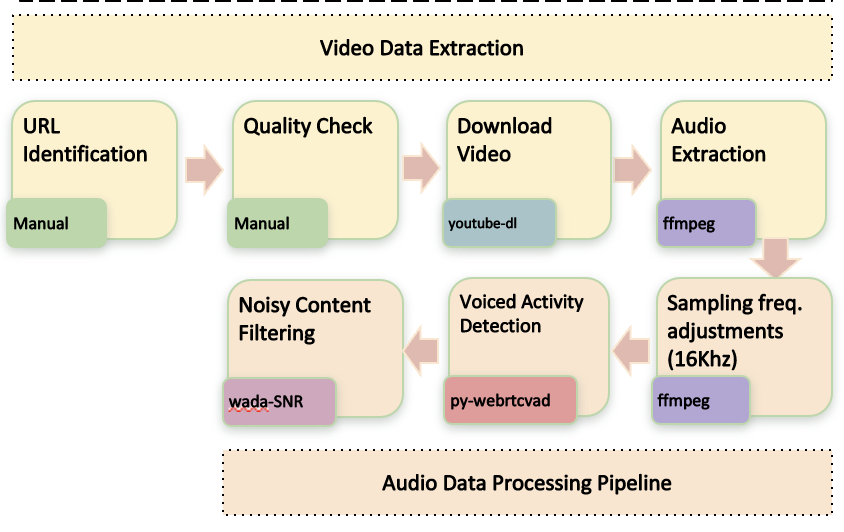

# Deployment using Flask
Flask is a deployment framwork supporting python right out of the box.
Our models on ULCA are running on Flask servers and the code can be found [here](https://github.com/AI4Bharat/IndicWav2Vec/tree/main/ULCA_Compliance)

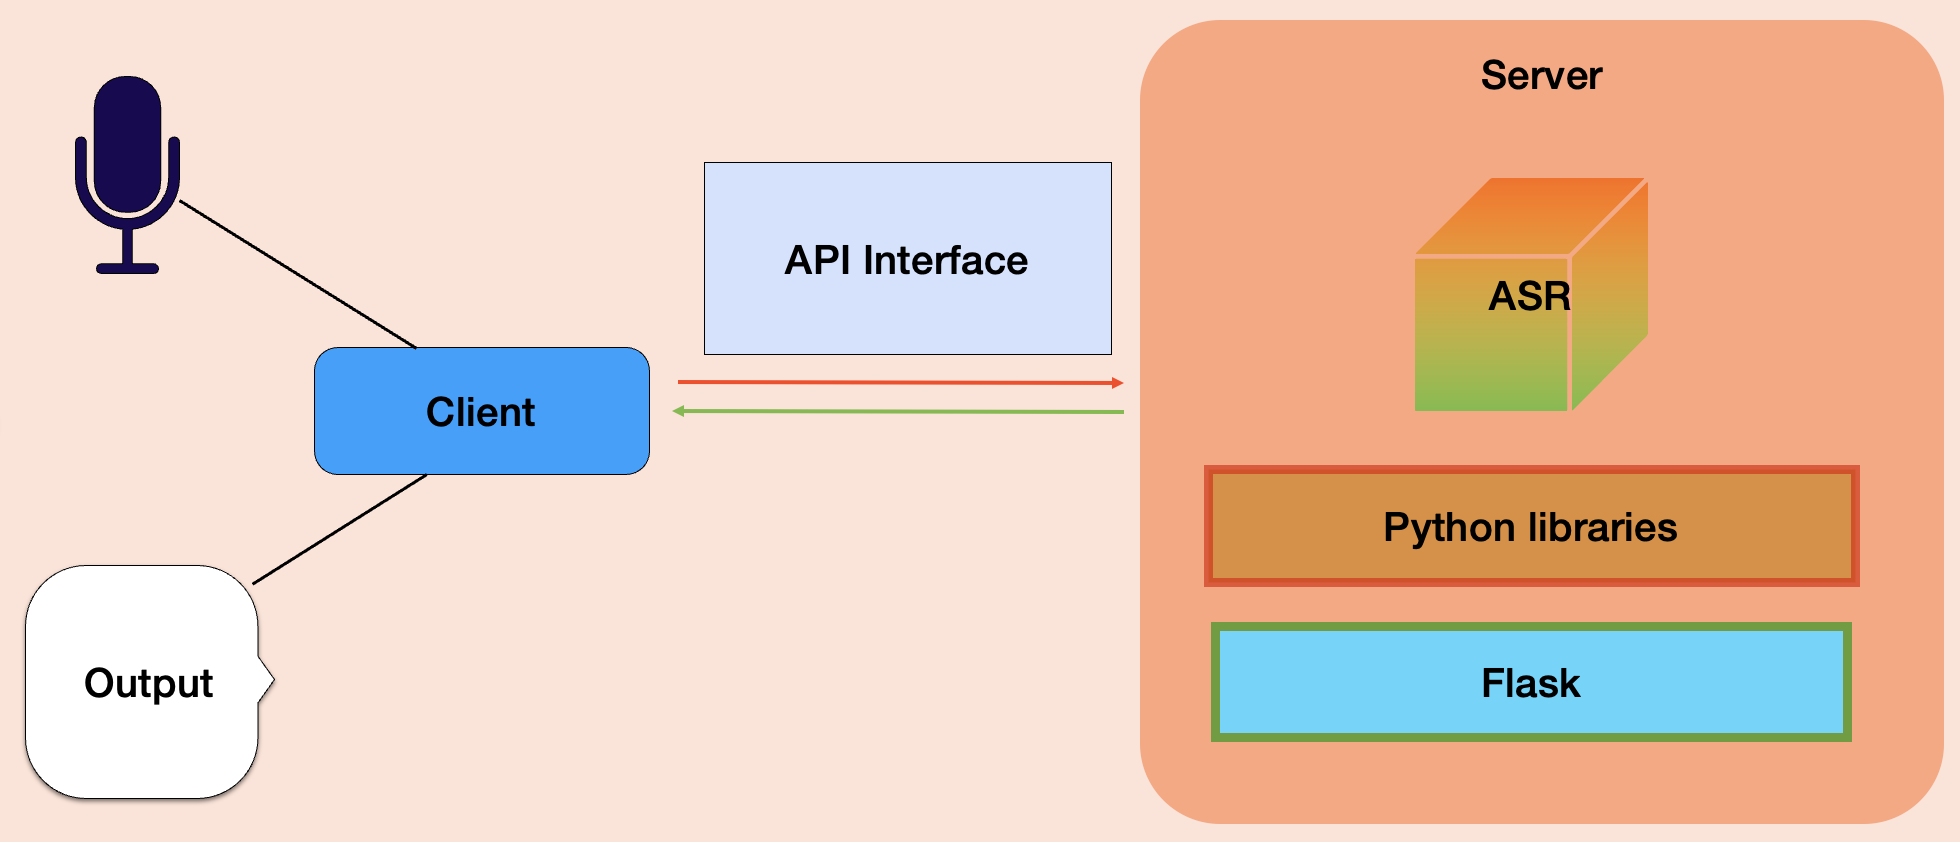